**Load data**

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

# Cloud type index = 37
# clear = 0
# stratus continental = 1
# stratus maritime = 2
# cumulus continental clean = 3
# cumulus continental polluted = 4
# cumulus maritime = 5
# cirrus = 6
# cirrus + water clouds (mixed) >= 7

USE_MIXED = True
USE_PRESSURE_TEMP = False
USE_SPECIFIC_CLOUDS = False
LOW_VIS_FRAC = False
low_vis_frac_train = 0.05
#low_vis_frac_test = 0.05
low_vis_threshold = 10000 #50000
cloud_types = [6] #0,1,2 ::: 0, 3, 4
noise_level = 0.01 # % of max
dnn_batch_size = 64

TEST_FRACTION = False

if USE_MIXED:
    filenames_vis = ['fog_data_vis_clear.dat', 'fog_data_vis_ice.dat', 'fog_data_vis_mixed.dat', 'fog_data_vis_water.dat']
    filenames_ir = ['fog_data_ir_clear.dat', 'fog_data_ir_ice.dat', 'fog_data_ir_mixed.dat', 'fog_data_ir_water.dat']
else:
    filenames_vis = ['fog_data_vis_clear.dat', 'fog_data_vis_ice.dat', 'fog_data_vis_water.dat']
    filenames_ir = ['fog_data_ir_clear.dat', 'fog_data_ir_ice.dat', 'fog_data_ir_water.dat']

target_i = 30 # Visibility index
if USE_PRESSURE_TEMP:
    features_i = np.concatenate((np.arange(4, 17), np.arange(20, 30), np.arange(31,36))) # 13 ir bands, 10 vis bands, 3 angles, pressure, temp
else:
    features_i = np.concatenate((np.arange(4, 17), np.arange(20, 30), np.arange(31,34)))

# Combine .dat files into one numpy array
data_ir_vis = []
for file_ir, file_vis in zip(filenames_ir, filenames_vis):
  raw_data_ir = pd.read_csv('fog_dataset/' + file_ir).to_numpy()
  raw_data_vis = pd.read_csv('fog_dataset/' + file_vis).to_numpy()

  data_ir = np.array([row[0].split() for row in raw_data_ir[25:]])
  data_vis = np.array([row[0].split()[1:] for row in raw_data_vis[41:]])

  if len(data_ir_vis) == 0:
    data_ir_vis = np.hstack([data_ir, data_vis])
  else:
    data_ir_vis = np.vstack([data_ir_vis, np.hstack([data_ir, data_vis])])

# Remove surface description to convert to float
data_ir_vis = data_ir_vis[:,:-1] 
data_ir_vis = data_ir_vis.astype(np.float32)

# 19 Data points contains nan. Not sure why. Band 32 culprit, 8th feature
nan_i = np.where(np.isnan(data_ir_vis))[0]
data_ir_vis = np.delete(data_ir_vis, nan_i, axis=0)


if USE_SPECIFIC_CLOUDS:
   data_ir_vis = data_ir_vis[np.isin(data_ir_vis[:, 37], cloud_types)]


X = data_ir_vis[:, features_i]
y = data_ir_vis[:,target_i]

noise_std_devs = np.zeros(features_i.shape)

for i, feature_i in enumerate(features_i):
    noise_std = (np.max(data_ir_vis[:,feature_i]) - np.min(data_ir_vis[:,feature_i])) * noise_level # 1% of mean or max??
    noise_std_devs[i] = noise_std

# Scaling features and noise standard deviations
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)
noise_stds_scaled = np.divide(noise_std_devs, feature_scaler.scale_)

# Scaling target
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y.reshape(-1, 1))


if not TEST_FRACTION:
    # First split: Separate out a test set (5% of the original dataset)
    X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y_scaled, test_size=(1/20))


if LOW_VIS_FRAC:
    if not TEST_FRACTION:
        low_vis_i = np.where(target_scaler.inverse_transform(y_temp) < low_vis_threshold)[0]
        high_vis_i = np.where(target_scaler.inverse_transform(y_temp) >= low_vis_threshold)[0]
    else:
        low_vis_i = np.where(target_scaler.inverse_transform(y_scaled) < low_vis_threshold)[0]
        high_vis_i = np.where(target_scaler.inverse_transform(y_scaled) >= low_vis_threshold)[0]


    n_high_vis = int(len(low_vis_i) / low_vis_frac_train * (1 - low_vis_frac_train))
    print(f'real frac: {len(low_vis_i)/len(y_scaled)}')
    if n_high_vis > len(high_vis_i):
        n_high_vis = len(high_vis_i)
        n_low_vis = int(low_vis_frac_train * n_high_vis)
        r_low_vis_i = np.random.choice(low_vis_i, n_low_vis, replace=False)
        low_vis_i = r_low_vis_i
    print(f'n_low_vis: {len(low_vis_i)}. n_high_vis: {n_high_vis}')
    r_high_vis_i = np.random.choice(high_vis_i, n_high_vis, replace=False)
    if not TEST_FRACTION:
        X_temp = np.vstack([X_temp[low_vis_i], X_temp[r_high_vis_i]])
        y_temp = np.vstack([y_temp[low_vis_i], y_temp[r_high_vis_i]])
    else:
        X_temp = np.vstack([X_scaled[low_vis_i], X_scaled[r_high_vis_i]])
        y_temp = np.vstack([y_scaled[low_vis_i], y_scaled[r_high_vis_i]])


if TEST_FRACTION:
    X_temp, X_test, y_temp, y_test = train_test_split(X_temp, y_temp, test_size=(1/19))
  

# Second split: Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=(1/19))

# Create noisy data
X_train_noisy = X_train + np.multiply(np.random.normal(0, 1, X_train.shape), noise_stds_scaled)
X_val_noisy = X_val + np.multiply(np.random.normal(0, 1, X_val.shape), noise_stds_scaled)
X_test_noisy = X_test + np.multiply(np.random.normal(0, 1, X_test.shape), noise_stds_scaled)

# Create class labels
y_train_label = np.where(target_scaler.inverse_transform(y_train) < low_vis_threshold, 1, 0)
y_val_label = np.where(target_scaler.inverse_transform(y_val) < low_vis_threshold, 1, 0)
y_test_label = np.where(target_scaler.inverse_transform(y_test) < low_vis_threshold, 1, 0)


# Create training data for DNN that adds noise to batches
training_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size=dnn_batch_size)
training_data_classes = tf.data.Dataset.from_tensor_slices((X_train, y_train_label)).batch(batch_size=dnn_batch_size)

def noise_map(features, labels):
    noise = tf.random.normal(shape=tf.shape(features))
    noise = noise * noise_stds_scaled
    noisy_features = features + noise
    return noisy_features, labels

training_data = training_data.map(noise_map)
training_data_classes = training_data_classes.map(noise_map)


**Anomaly detection (Data has to be configured differntly using the TEST_FRACTION flag)**

KNN (anomaly detection)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train_noisy, y_train_label)

# Predict whether each data point is an anomaly (0 for anomalies, 1 for normal data)
predictions = clf.predict(X_test_noisy)

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
print(classification_report(y_test_label, predictions))
cm = confusion_matrix(y_test_label, predictions)
plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Initialize t-SNE model with desired parameters
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data to 2 dimensions
X_tsne = tsne.fit_transform(X_test_noisy)                                                                           #UMAP

print(np.sum(predictions))
print(np.sum(y_test_label))

# Visualize the results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=predictions, cmap='viridis', s = 10, alpha=0.7)
plt.colorbar(label="low vis = 1")
plt.title("Anomaly Detection using KNN")
plt.show()

# Visualize the results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test_label, cmap='viridis', s = 10, alpha=0.7)
plt.colorbar(label="Visibility classes")
plt.title("Predictions")
plt.show()

Isolation forest (anomaly deteciton)

0.052870090634441085
0.11388744716453697
0.11388744716453697
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1254
           1       0.00      0.00      0.00        70

    accuracy                           0.90      1324
   macro avg       0.47      0.47      0.47      1324
weighted avg       0.89      0.90      0.90      1324



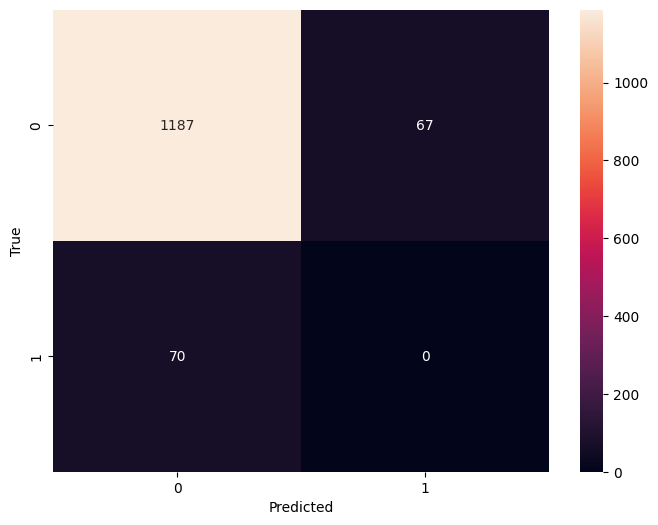

In [11]:
from sklearn.ensemble import IsolationForest
import numpy as np

# Create an Isolation Forest model
fog_frac = np.sum(y_test_label) / len(y_test_label)

isolation_forest = IsolationForest(contamination=fog_frac)  # Set contamination to your expected proportion of anomalies

# Train the model
isolation_forest.fit(X_train_noisy, y_train_label)  # Including labels during training

# Predict outliers/anomalies
anomaly_scores = isolation_forest.decision_function(X_test_noisy)


threshold = np.percentile(anomaly_scores, 95)  # RUN THRESHOLD LOOP HERE

print(threshold)

predicted_labels = np.where(anomaly_scores < threshold, 0, 1)  # Anomalies marked as 1, normal instances marked as -1

print(threshold)
# Evaluate the model
from sklearn.metrics import classification_report
print(classification_report(y_test_label, predicted_labels))
cm = confusion_matrix(y_test_label, predicted_labels)
plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

One Class SVM (anomaly detection)

In [12]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, average_precision_score


# Train One-Class SVM
ocsvm = OneClassSVM(gamma='auto')
#ocsvm.fit(X_train_noisy[np.where(y_train_label == 0)[0]])  # Fit on high vis pixels only
ocsvm.fit(X_train_noisy)  # Fit on all pixels


# Predict anomaly scores
anomaly_scores = ocsvm.decision_function(X_test_noisy)


thresholds = np.arange(-2000, 1000, 50)
avg_precisions = np.zeros(thresholds.shape)
accuracies = np.zeros(thresholds.shape)
#t = 0
#predicted_labels = (anomaly_scores < t).astype(int)
#print(average_precision_score(y_test_label, predicted_labels))

# Loop to check different thresholds
for i, t in enumerate(thresholds):
    predicted_labels = (anomaly_scores < t).astype(int)
    avg_precisions[i] = average_precision_score(y_test_label, predicted_labels)
    accuracies[i] = accuracy_score(y_test_label, predicted_labels)




# print(classification_report(y_test_label, predicted_labels))
# cm = confusion_matrix(y_test_label, predicted_labels)
# plt.figure(figsize=(8,6)) 
# sn.heatmap(cm, annot=True, fmt='d')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()


In [3]:
print(f'Accurcy: {np.max(accuracies)} at t = {thresholds[np.argmax(accuracies)]}')
print(f'Avg Precision: {np.max(avg_precisions)} at t = {thresholds[np.argmax(avg_precisions)]}')

Accurcy: 0.8432 at t = -2000
Avg Precision: 0.31060546158748836 at t = -1250


Autoencoder (Anomaly detection)

In [13]:
import numpy as np
import tensorflow as tf
from keras import layers, models


# Define autoencoder architecture
input_dim = X_train.shape[1]
encoding_dim = 32

input_data = tf.keras.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_data)
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = models.Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(X_train_noisy, y_train_label, epochs=50, batch_size=128, validation_split=0.2)

# Define reconstruction error threshold
reconstruction_errors = np.mean(np.square(X_test_noisy - autoencoder.predict(X_test_noisy)), axis=1)
threshold = np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors)

# Predict anomalies based on the threshold
y_pred = np.where(reconstruction_errors > threshold, 1, 0)

# Evaluate performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test_label, y_pred)
precision = precision_score(y_test_label, y_pred)
recall = recall_score(y_test_label, y_pred)
f1 = f1_score(y_test_label, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Epoch 1/50


2024-03-07 10:11:35.932030: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f40a80068d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-07 10:11:35.932063: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-03-07 10:11:35.948421: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-07 10:11:36.024721: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


 83/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2132

I0000 00:00:1709806296.459662 1152828 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1814 - val_loss: 0.0570
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0546 - val_loss: 0.0505
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0478 - val_loss: 0.0493
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0467 - val_loss: 0.0489
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0462 - val_loss: 0.0487
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0452 - val_loss: 0.0485
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0491 - val_loss: 0.0485
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0485 - val_loss: 0.0483
Epoch 9/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0488 - val_loss: 0.0482
Epoch 10/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0472 - val_loss: 0.0480
Epoch 11/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0497 - val_loss: 0.0478
Epoch 12/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

**Classification models**

FFNN / MLP Classifier

Epoch 1/60


/home/edgelab/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


W0000 00:00:1709563243.831410 1026773 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


287/287 - 10s - 35ms/step - accuracy: 0.7862 - loss: 0.5845 - val_accuracy: 0.8163 - val_loss: 0.4920
Epoch 2/60
287/287 - 1s - 3ms/step - accuracy: 0.8216 - loss: 0.4556 - val_accuracy: 0.8291 - val_loss: 0.4411
Epoch 3/60
287/287 - 1s - 3ms/step - accuracy: 0.8265 - loss: 0.4162 - val_accuracy: 0.8222 - val_loss: 0.4087
Epoch 4/60
287/287 - 1s - 3ms/step - accuracy: 0.8304 - loss: 0.3933 - val_accuracy: 0.8261 - val_loss: 0.3915
Epoch 5/60
287/287 - 1s - 3ms/step - accuracy: 0.8303 - loss: 0.3809 - val_accuracy: 0.8222 - val_loss: 0.3836
Epoch 6/60
287/287 - 1s - 3ms/step - accuracy: 0.8344 - loss: 0.3669 - val_accuracy: 0.8350 - val_loss: 0.3721
Epoch 7/60
287/287 - 1s - 2ms/step - accuracy: 0.8342 - loss: 0.3587 - val_accuracy: 0.8251 - val_loss: 0.3677
Epoch 8/60
287/287 - 1s - 2ms/step - accuracy: 0.8349 - loss: 0.3533 - val_accuracy: 0.8251 - val_loss: 0.3653
Epoch 9/60
287/287 - 1s - 3ms/step - accuracy: 0.8365 - loss: 0.3483 - val_accuracy: 0.8330 - val_loss: 0.3576
Epoch 10/6

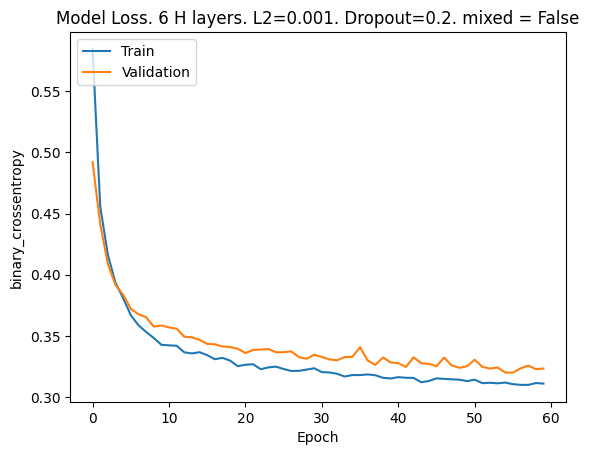

              precision    recall  f1-score   support

           0       0.95      0.90      0.93      2103
           1       0.59      0.77      0.67       397

    accuracy                           0.88      2500
   macro avg       0.77      0.84      0.80      2500
weighted avg       0.90      0.88      0.89      2500



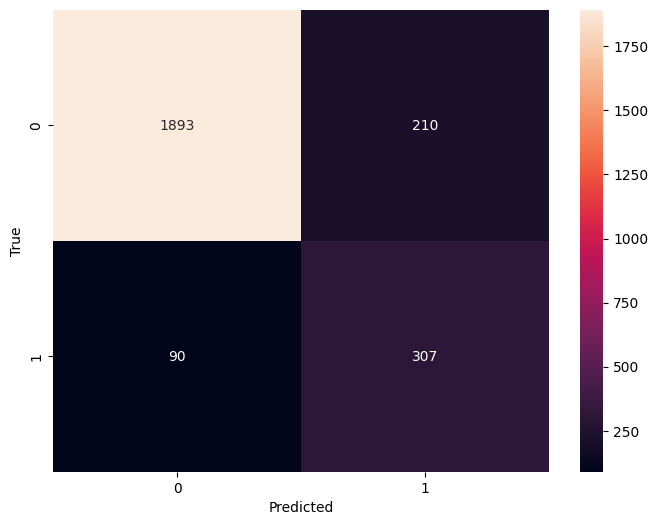

In [81]:
from keras import layers
from keras import regularizers
from keras.layers import Attention
from sklearn.metrics import classification_report


# Define the model
ff_model = tf.keras.Sequential([
    # Input layer
    layers.Dense(len(features_i), activation='relu', input_shape=(len(features_i),)),
    
    # Hidden layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),


    # Output layer
    layers.Dense(1, activation='sigmoid') 
])

# Compile the model for classification
ff_model.compile(optimizer='adam',
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

#history = ff_model.fit(X_train, y_train, epochs = 500, batch_size = 64, validation_data=(X_val, y_val))
history = ff_model.fit(training_data_classes, epochs = 60, validation_data=(X_val_noisy, y_val_label), verbose=2)


y_pred = ff_model.predict(X_test)

y_pred_label = (y_pred > 0.5 ).astype(int) 
cm = confusion_matrix(y_test_label, y_pred_label)


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print(classification_report(y_test_label, y_pred_label))

plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# for t in thresholds:
#     y_pred_label = (y_pred > t ).astype(int)
#     plt.figure(figsize=(8,6)) 
#     sn.heatmap(confusion_matrix(y_test_label, y_pred_label), annot=True, fmt='d')
#     plt.title(f't = {t}')
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.show()


Random Forest Classifier

/home/edgelab/.local/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

           0       0.95      0.90      0.92      2103
           1       0.59      0.75      0.66       397

    accuracy                           0.88      2500
   macro avg       0.77      0.83      0.79      2500
weighted avg       0.89      0.88      0.88      2500



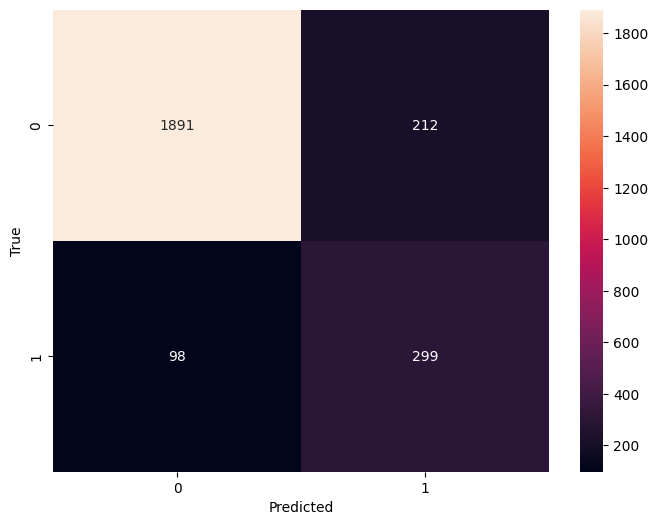

In [82]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_noisy, y_train_label)

y_pred_label = rf_model.predict(X_test_noisy)

print(classification_report(y_test_label, y_pred_label))
cm = confusion_matrix(y_test_label, y_pred_label)
plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Gradient Boosted Classifier

/home/edgelab/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.95      0.90      0.93      2103
           1       0.59      0.77      0.67       397

    accuracy                           0.88      2500
   macro avg       0.77      0.83      0.80      2500
weighted avg       0.90      0.88      0.88      2500



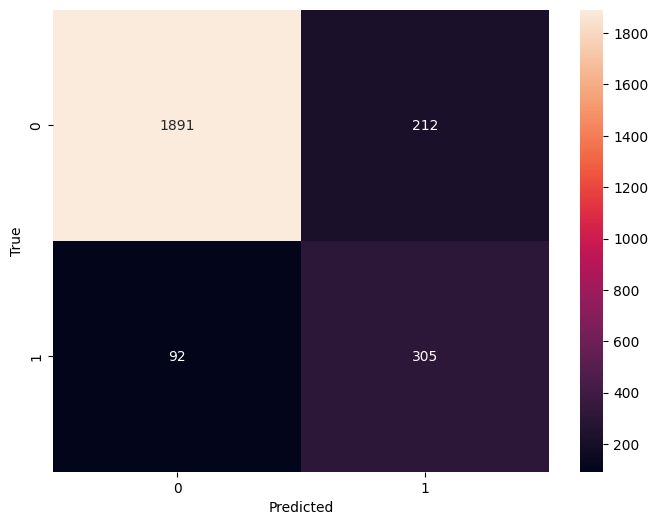

In [83]:
from sklearn.ensemble import GradientBoostingClassifier

rf_model = GradientBoostingClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_noisy, y_train_label)

y_pred_label = rf_model.predict(X_test_noisy)

print(classification_report(y_test_label, y_pred_label))
cm = confusion_matrix(y_test_label, y_pred_label)
plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Histograms of target value (visibility)**

All target values

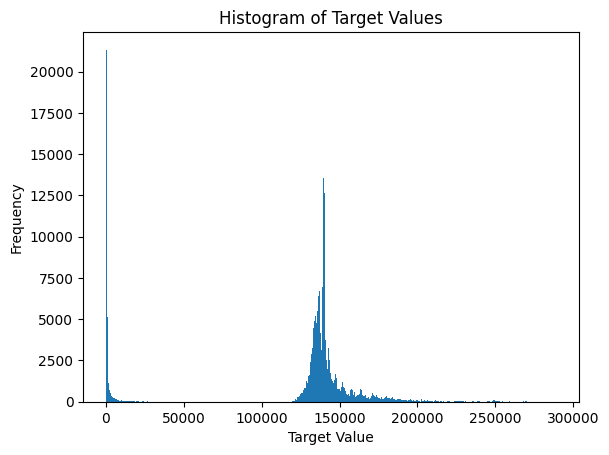

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(y, bins=500)
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.title("Histogram of Target Values")
plt.show()

Logarithm of all target values

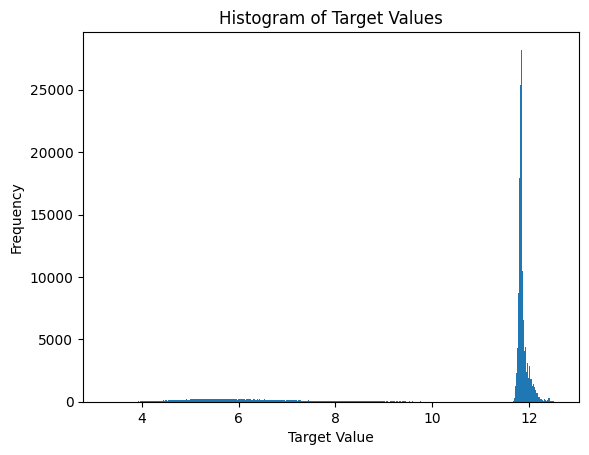

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(np.log(y), bins=500)
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.title("Histogram of Target Values")
plt.show()

"Low visibility" Target values

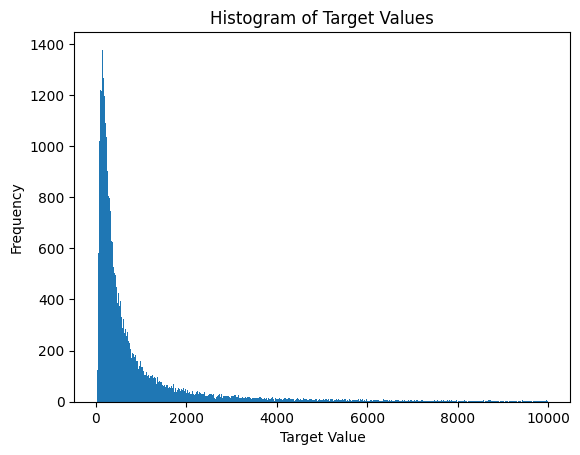

In [5]:
import matplotlib.pyplot as plt
import numpy as np

y_low_vis = y[y < low_vis_threshold]

plt.hist(y_low_vis, bins=500)
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.title("Histogram of Target Values")
plt.show()

Logarithm of "Low visibility" target values

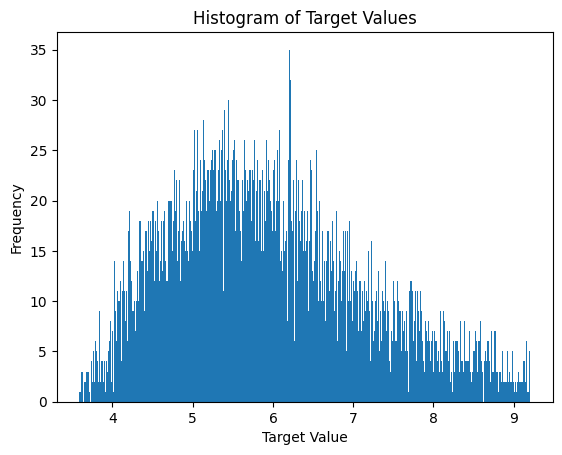

In [23]:
import matplotlib.pyplot as plt
import numpy as np

y_low_vis = y[y < low_vis_threshold]

plt.hist(np.log(y_low_vis), bins=500)
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.title("Histogram of Target Values")
plt.show()

In [12]:
low_vis_i_train = np.where(target_scaler.inverse_transform(y_train) < low_vis_threshold)[0]
X_low_vis_train = X_train_noisy[low_vis_i_train]
y_low_vis_train = np.log(target_scaler.inverse_transform(y_train[low_vis_i_train]))

low_vis_i_val = np.where(target_scaler.inverse_transform(y_val) < low_vis_threshold)[0]
X_low_vis_val = X_val_noisy[low_vis_i_val]
y_low_vis_val = np.log(target_scaler.inverse_transform(y_val[low_vis_i_val]))

low_vis_i_test = np.where(target_scaler.inverse_transform(y_test) < low_vis_threshold)[0]
X_low_vis_test = X_test_noisy[low_vis_i_test]
y_low_vis_test = np.log(target_scaler.inverse_transform(y_test[low_vis_i_test]))

Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_noisy, y_train.ravel())

y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
residuals = y_test.ravel() - y_pred 

print("Mean Squared Error:", mse)

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()


/home/edgelab/.local/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error: 28.16854382106407


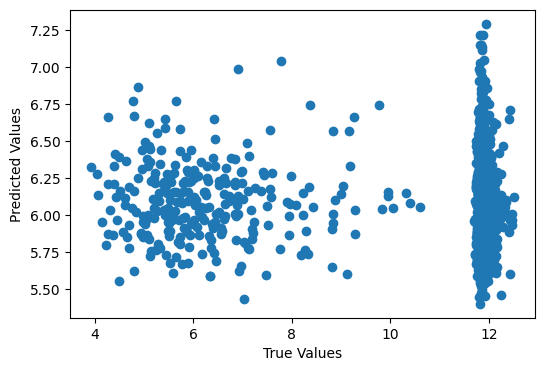

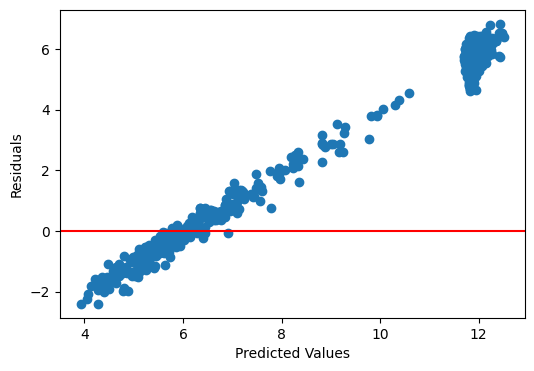

In [10]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
#rf_model.fit(X_train_noisy, y_train.ravel())
rf_model.fit(X_low_vis, y_regression)

#y_pred = rf_model.predict(X_test)
y_pred = rf_model.predict(X_low_vis_test)
mse = mean_squared_error(y_regression_test, y_pred)
residuals = y_regression_test.ravel() - y_pred 

print("Mean Squared Error:", mse)

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_regression_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_regression_test, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()


Gradient Boosting Regressor

Mean Squared Error: 0.6247968936755467


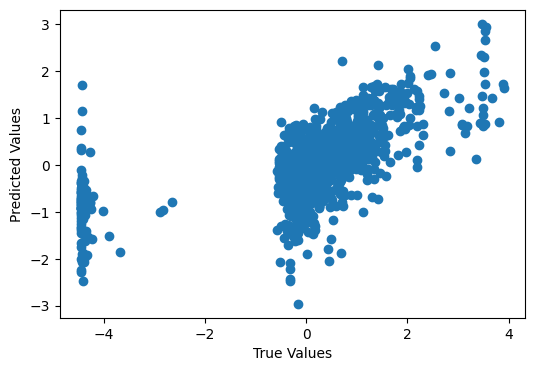

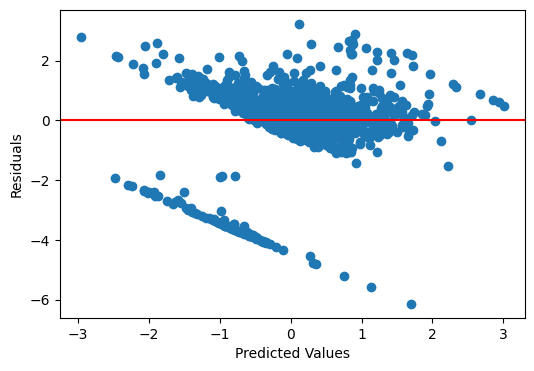

In [28]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3)
gb_model.fit(X_train, y_train.ravel())

y_pred = gb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
residuals = y_test.ravel() - y_pred

print("Mean Squared Error:", mse)

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()

DNN Regression

In [13]:
from keras import layers
from keras import regularizers

# Define the model
ff_model = tf.keras.Sequential([
    # Input layer
    layers.Dense(len(features_i), activation='relu', input_shape=(len(features_i),)),

    # Hidden layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    # layers.Dropout(0.2),
    # layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    # layers.Dropout(0.2),
    # layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

    # Output layer
    layers.Dense(1, activation='linear')
])

# Compile the model for regression
ff_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# tf.optimizers.Adam(learning_rate=1e-3)
#model.summary()

#history = ff_model.fit(X_train, y_train, epochs = 500, batch_size = 64, validation_data=(X_val, y_val))
#history = ff_model.fit(training_data, epochs = 150, validation_data=(X_val_noisy, y_val))
history = ff_model.fit(X_low_vis_train, y_low_vis_train, epochs = 150, validation_data=(X_low_vis_val, y_low_vis_val))


# y_pred = ff_model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# residuals = y_test - y_pred 
# print(f'Mean squared error: {mse}')

y_pred = ff_model.predict(X_low_vis_test)
mse = mean_squared_error(y_low_vis_test, y_pred)
residuals = y_test - y_pred 
print(f'Mean squared error: {mse}')

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()

Epoch 1/150


/home/edgelab/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-03-07 12:55:29.966164: I external/local_xla/xla/service/service.cc:168] XLA service 0x5596b416ee50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-07 12:55:29.966195: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-03-07 12:55:30.001400: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-07 12:55:30.289528: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


 70/229 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.6613 - mean_absolute_error: 3.9772

I0000 00:00:1709816133.365346 1157602 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 11.5962 - mean_absolute_error: 2.6640 - val_loss: 2.4031 - val_mean_absolute_error: 1.1471
Epoch 2/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.1564 - mean_absolute_error: 1.1100 - val_loss: 2.1551 - val_mean_absolute_error: 1.0885
Epoch 3/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7631 - mean_absolute_error: 0.9869 - val_loss: 1.8129 - val_mean_absolute_error: 0.9812
Epoch 4/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5932 - mean_absolute_error: 0.9452 - val_loss: 1.7863 - val_mean_absolute_error: 0.9763
Epoch 5/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5147 - mean_absolute_error: 0.9223 - val_loss: 1.4071 - val_mean_absolute_error: 0.8759
Epoch 6/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4693 - mean_absolute_error: 0.9125 - val_loss: 1.4352 - val_mean_absolute_error: 0.8843
Epoch 7/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3841 - mean_absolute_error: 0.8792 - val_

ValueError: operands could not be broadcast together with shapes (2500,1) (416,1) 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Mean squared error: 1.2858693599700928


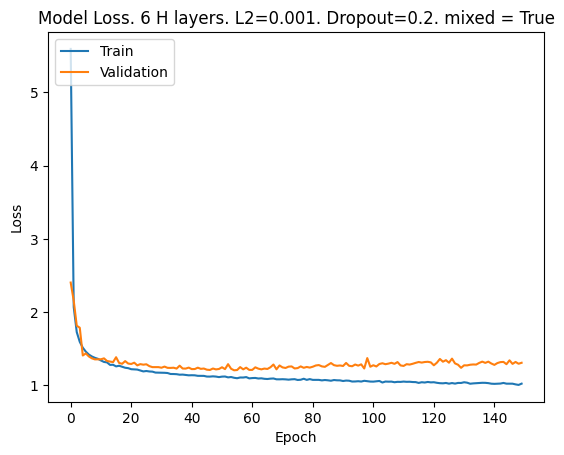

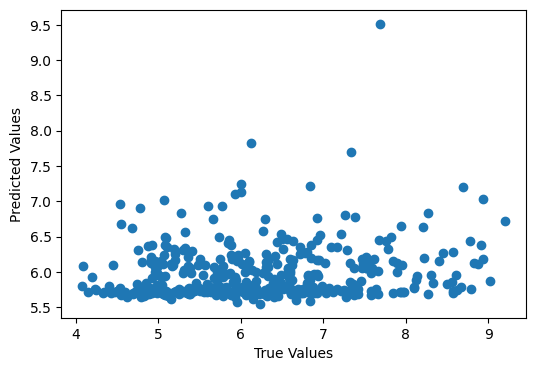

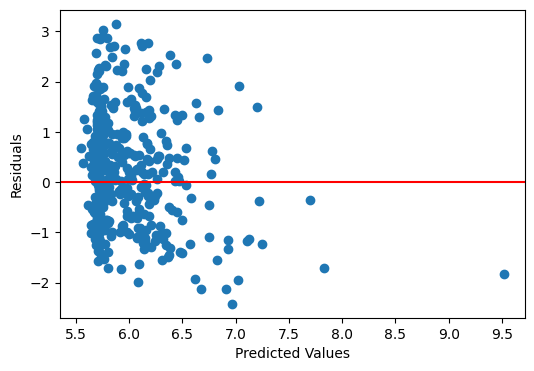

In [14]:
y_pred = ff_model.predict(X_low_vis_test)
mse = mean_squared_error(y_low_vis_test, y_pred)
residuals = y_low_vis_test - y_pred 
print(f'Mean squared error: {mse}')

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_low_vis_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()

Tabnet

/home/edgelab/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.73769 | val_0_auc: 0.78765 |  0:00:00s
epoch 1  | loss: 0.48379 | val_0_auc: 0.84316 |  0:00:01s
epoch 2  | loss: 0.44894 | val_0_auc: 0.8545  |  0:00:01s
epoch 3  | loss: 0.42888 | val_0_auc: 0.86877 |  0:00:02s
epoch 4  | loss: 0.41115 | val_0_auc: 0.87171 |  0:00:02s
epoch 5  | loss: 0.39886 | val_0_auc: 0.88586 |  0:00:03s
epoch 6  | loss: 0.39222 | val_0_auc: 0.87935 |  0:00:03s
epoch 7  | loss: 0.38672 | val_0_auc: 0.8826  |  0:00:04s
epoch 8  | loss: 0.38543 | val_0_auc: 0.89496 |  0:00:04s
epoch 9  | loss: 0.37492 | val_0_auc: 0.89691 |  0:00:05s
epoch 10 | loss: 0.36736 | val_0_auc: 0.90099 |  0:00:05s
epoch 11 | loss: 0.36501 | val_0_auc: 0.89947 |  0:00:06s
epoch 12 | loss: 0.36368 | val_0_auc: 0.90034 |  0:00:06s
epoch 13 | loss: 0.3585  | val_0_auc: 0.90241 |  0:00:07s
epoch 14 | loss: 0.35671 | val_0_auc: 0.89732 |  0:00:08s
epoch 15 | loss: 0.35331 | val_0_auc: 0.90791 |  0:00:08s
epoch 16 | loss: 0.3494  | val_0_auc: 0.90893 |  0:00:09s
epoch 17 | los

/home/edgelab/.local/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


              precision    recall  f1-score   support

           0       0.95      0.90      0.93      2103
           1       0.60      0.75      0.67       397

    accuracy                           0.88      2500
   macro avg       0.77      0.83      0.80      2500
weighted avg       0.89      0.88      0.89      2500



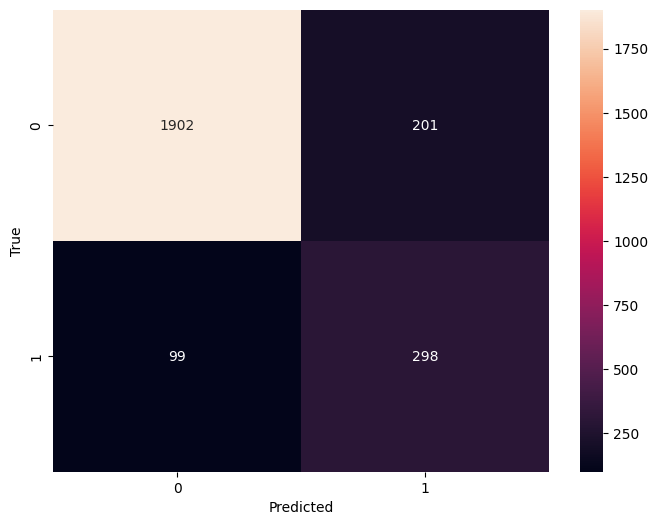

In [84]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

clf = TabNetClassifier()

clf.fit(
  X_train_noisy, y_train_label.ravel(), max_epochs=125,
  eval_set=[(X_val_noisy, y_val_label.ravel())]
)
preds = clf.predict(X_test_noisy)

print(classification_report(y_test_label, preds))
cm = confusion_matrix(y_test_label, preds)

plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

DNN Classification

In [ ]:
from keras import layers
from keras import regularizers
from keras.layers import Attention

# Define the model
ff_model = tf.keras.Sequential([
    # Input layer
    layers.Dense(len(features_i), activation='relu', input_shape=(len(features_i),)),
    
    # Hidden layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)),


    # Output layer
    layers.Dense(1, activation='sigmoid') 
])

# Compile the model for classification
ff_model.compile(optimizer='adam',
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

#history = ff_model.fit(X_train, y_train, epochs = 500, batch_size = 64, validation_data=(X_val, y_val))
history = ff_model.fit(training_data_classes, epochs = 10, validation_data=(X_val_noisy, y_val_label))


y_pred = ff_model.predict(X_test)

y_pred_label = (y_pred > 0.5 ).astype(int) 
cm = confusion_matrix(y_test_label, y_pred_label)

from sklearn.metrics import classification_report

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print(classification_report(y_test_label, y_pred_label))

plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

from sklearn.metrics import accuracy_score

thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for t in thresholds:
    y_pred_label = (y_pred > t ).astype(int)
    print(f'threshold: {t}')
    print(accuracy_score(y_test_label, y_pred_label))


DNN Classification with attention

Epoch 1/60


W0000 00:00:1709563854.025916 1026772 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


287/287 - 4s - 13ms/step - accuracy: 0.7996 - loss: 0.5411 - val_accuracy: 0.8261 - val_loss: 0.4684
Epoch 2/60
287/287 - 1s - 2ms/step - accuracy: 0.8283 - loss: 0.4436 - val_accuracy: 0.8350 - val_loss: 0.4350
Epoch 3/60
287/287 - 1s - 3ms/step - accuracy: 0.8322 - loss: 0.4147 - val_accuracy: 0.8301 - val_loss: 0.4120
Epoch 4/60
287/287 - 1s - 3ms/step - accuracy: 0.8366 - loss: 0.3981 - val_accuracy: 0.8281 - val_loss: 0.3995
Epoch 5/60
287/287 - 1s - 3ms/step - accuracy: 0.8409 - loss: 0.3851 - val_accuracy: 0.8369 - val_loss: 0.3868
Epoch 6/60
287/287 - 1s - 3ms/step - accuracy: 0.8419 - loss: 0.3741 - val_accuracy: 0.8360 - val_loss: 0.3792
Epoch 7/60
287/287 - 1s - 3ms/step - accuracy: 0.8417 - loss: 0.3690 - val_accuracy: 0.8428 - val_loss: 0.3703
Epoch 8/60
287/287 - 1s - 2ms/step - accuracy: 0.8443 - loss: 0.3604 - val_accuracy: 0.8418 - val_loss: 0.3613
Epoch 9/60
287/287 - 1s - 2ms/step - accuracy: 0.8442 - loss: 0.3566 - val_accuracy: 0.8448 - val_loss: 0.3607
Epoch 10/60

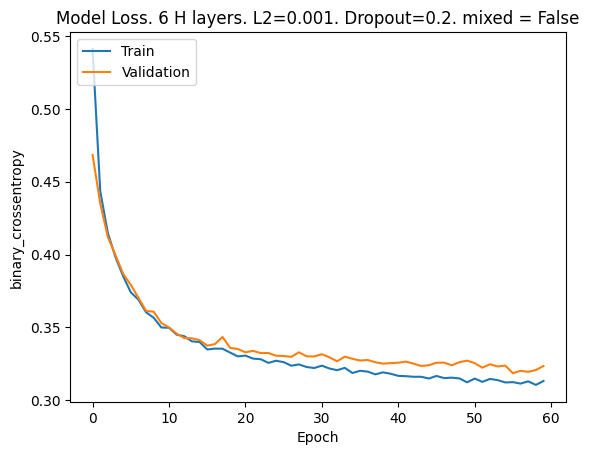

              precision    recall  f1-score   support

           0       0.96      0.87      0.92      2103
           1       0.55      0.81      0.65       397

    accuracy                           0.86      2500
   macro avg       0.75      0.84      0.78      2500
weighted avg       0.89      0.86      0.87      2500



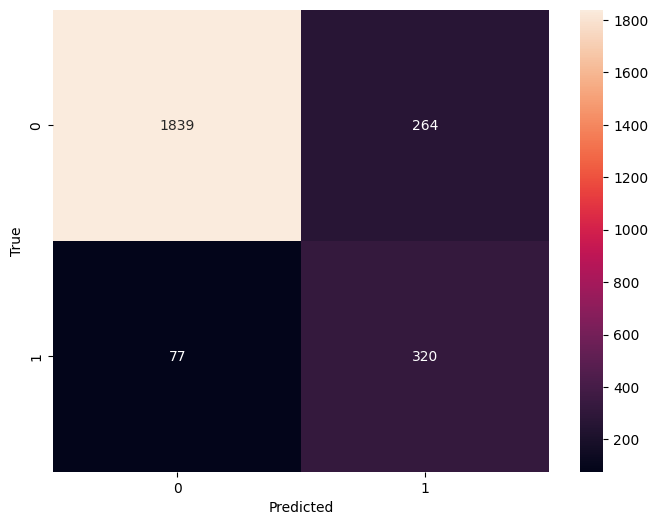

In [88]:
from keras import layers
from keras import regularizers
from keras.layers import Attention, Input, Flatten

# Define the input layer
input_layer = Input(shape=(len(features_i),))

# Hidden layers
hidden_layer_1 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_layer)

# Flatten the output of the hidden layer
flatten_layer = Flatten()(hidden_layer_1)

# Reshape to ensure it's 2D
reshaped_layer = layers.Reshape((1, -1))(flatten_layer)

# Attention layer
attention = Attention()([reshaped_layer, reshaped_layer])

# Additional hidden layers
hidden_layer_2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(attention)
hidden_layer_3 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(hidden_layer_2)
hidden_layer_4 = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001))(hidden_layer_3)

# Output layer
output_layer = layers.Dense(1, activation='sigmoid')(hidden_layer_4)

# Define the model
ff_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model for classification
ff_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

history = ff_model.fit(training_data_classes, epochs = 60, validation_data=(X_val_noisy, y_val_label), verbose=2)

y_pred = ff_model.predict(X_test)

y_pred_label = (y_pred > 0.5 ).astype(int).flatten()
cm = confusion_matrix(y_test_label, y_pred_label)

from sklearn.metrics import classification_report

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print(classification_report(y_test_label, y_pred_label))

plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [68]:
from keras import layers
from keras import regularizers
from keras.layers import Attention, Input, Flatten

# Define the input layer
input_layer = Input(shape=(len(features_i),))

# Flatten the output of the input layer
flatten_layer = Flatten()(input_layer)

# Reshape to ensure it's 2D
reshaped_layer = layers.Reshape((1, -1))(flatten_layer)

# Attention layer
attention = Attention()([reshaped_layer, reshaped_layer])

# Hidden layers
hidden_layer_1 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(attention)

# Additional hidden layers
hidden_layer_2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(hidden_layer_1)
hidden_layer_3 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(hidden_layer_2)
hidden_layer_4 = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001))(hidden_layer_3)

# Output layer
output_layer = layers.Dense(1, activation='sigmoid')(hidden_layer_4)

# Define the model
ff_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model for classification
ff_model.compile(optimizer='adam',
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

Epoch 1/60


286/286 - 10s - 34ms/step - accuracy: 0.7750 - loss: 0.5962 - val_accuracy: 0.8187 - val_loss: 0.4779
Epoch 2/60
286/286 - 1s - 4ms/step - accuracy: 0.8151 - loss: 0.4856 - val_accuracy: 0.8158 - val_loss: 0.4415
Epoch 3/60
286/286 - 1s - 5ms/step - accuracy: 0.8188 - loss: 0.4478 - val_accuracy: 0.8167 - val_loss: 0.4099
Epoch 4/60
286/286 - 1s - 4ms/step - accuracy: 0.8200 - loss: 0.4281 - val_accuracy: 0.8177 - val_loss: 0.3963
Epoch 5/60
286/286 - 1s - 4ms/step - accuracy: 0.8260 - loss: 0.4099 - val_accuracy: 0.8187 - val_loss: 0.3858
Epoch 6/60
286/286 - 1s - 4ms/step - accuracy: 0.8281 - loss: 0.3972 - val_accuracy: 0.8305 - val_loss: 0.3748
Epoch 7/60
286/286 - 1s - 4ms/step - accuracy: 0.8309 - loss: 0.3892 - val_accuracy: 0.8325 - val_loss: 0.3658
Epoch 8/60
286/286 - 1s - 4ms/step - accuracy: 0.8314 - loss: 0.3841 - val_accuracy: 0.8365 - val_loss: 0.3611
Epoch 9/60
286/286 - 1s - 4ms/step - accuracy: 0.8332 - loss: 0.3762 - val_accuracy: 0.8374 - val_loss: 0.3605
Epoch 10/6

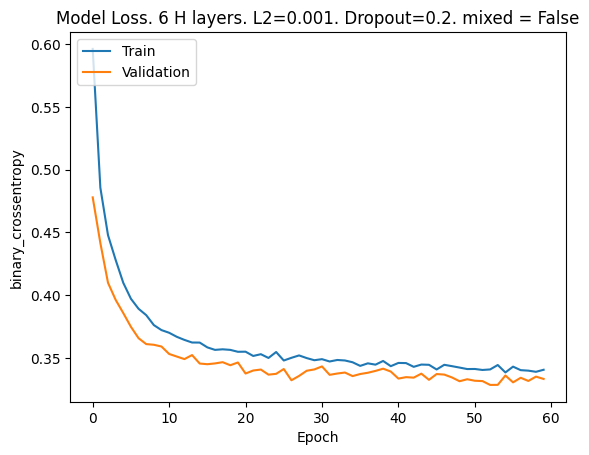

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2074
           1       0.65      0.69      0.67       426

    accuracy                           0.88      2500
   macro avg       0.79      0.81      0.80      2500
weighted avg       0.89      0.88      0.88      2500



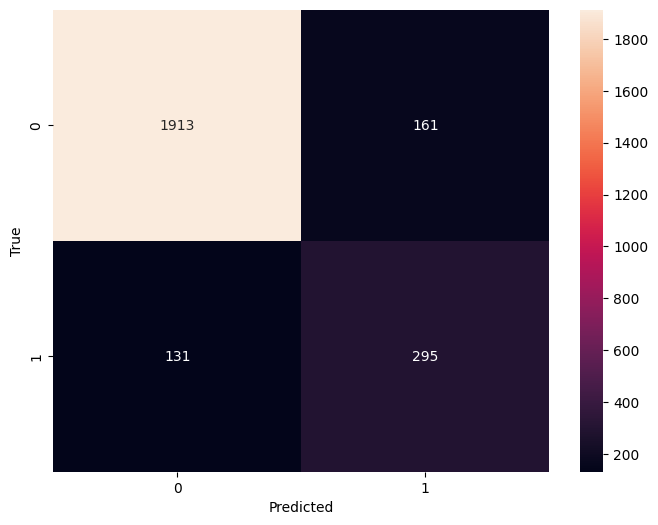

In [4]:
from keras import layers
from keras import regularizers
from keras.layers import Attention, Input, Reshape

# Define the input layer
input_layer = Input(shape=(len(features_i),))

# Reshape input to include a singleton dimension for timestep
reshaped_input = Reshape((1, len(features_i)))(input_layer)

# Attention layer
attention = Attention()([reshaped_input, reshaped_input])

# Flatten the attention output to merge the timestep dimension
flattened_attention = layers.Flatten()(attention)
dropout_0 = layers.Dropout(0)(flattened_attention)


# Hidden layers
hidden_layer_1 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_0)
dropout_1 = layers.Dropout(0.2)(hidden_layer_1)
hidden_layer_2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_1)
dropout_2 = layers.Dropout(0.2)(hidden_layer_2)
hidden_layer_3 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_2)
dropout_3 = layers.Dropout(0.2)(hidden_layer_3)
hidden_layer_4 = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_3)

# Output layer
output_layer = layers.Dense(1, activation='sigmoid')(hidden_layer_4)

# Define the model
ff_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model for classification
ff_model.compile(optimizer='adam',
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

history = ff_model.fit(training_data_classes, epochs = 60, validation_data=(X_val_noisy, y_val_label), verbose=2)


y_pred = ff_model.predict(X_test)

y_pred_label = (y_pred > 0.5 ).astype(int) 
cm = confusion_matrix(y_test_label, y_pred_label)

from sklearn.metrics import classification_report

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print(classification_report(y_test_label, y_pred_label))

plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

DNN for regression with Multi head attention

Epoch 1/60


286/286 - 11s - 40ms/step - accuracy: 0.7814 - loss: 0.5589 - val_accuracy: 0.8167 - val_loss: 0.4440
Epoch 2/60
286/286 - 1s - 3ms/step - accuracy: 0.8158 - loss: 0.4483 - val_accuracy: 0.8187 - val_loss: 0.4081
Epoch 3/60
286/286 - 1s - 3ms/step - accuracy: 0.8190 - loss: 0.4182 - val_accuracy: 0.8227 - val_loss: 0.3909
Epoch 4/60
286/286 - 1s - 3ms/step - accuracy: 0.8208 - loss: 0.4045 - val_accuracy: 0.8266 - val_loss: 0.3755
Epoch 5/60
286/286 - 1s - 3ms/step - accuracy: 0.8245 - loss: 0.3931 - val_accuracy: 0.8266 - val_loss: 0.3698
Epoch 6/60
286/286 - 1s - 3ms/step - accuracy: 0.8259 - loss: 0.3867 - val_accuracy: 0.8266 - val_loss: 0.3668
Epoch 7/60
286/286 - 1s - 3ms/step - accuracy: 0.8265 - loss: 0.3794 - val_accuracy: 0.8305 - val_loss: 0.3590
Epoch 8/60
286/286 - 1s - 3ms/step - accuracy: 0.8272 - loss: 0.3759 - val_accuracy: 0.8325 - val_loss: 0.3562
Epoch 9/60
286/286 - 1s - 3ms/step - accuracy: 0.8287 - loss: 0.3726 - val_accuracy: 0.8296 - val_loss: 0.3542
Epoch 10/6

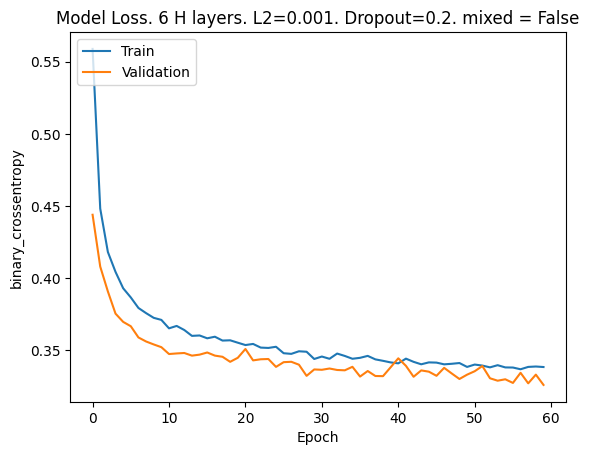

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2074
           1       0.64      0.71      0.67       426

    accuracy                           0.88      2500
   macro avg       0.79      0.81      0.80      2500
weighted avg       0.89      0.88      0.89      2500



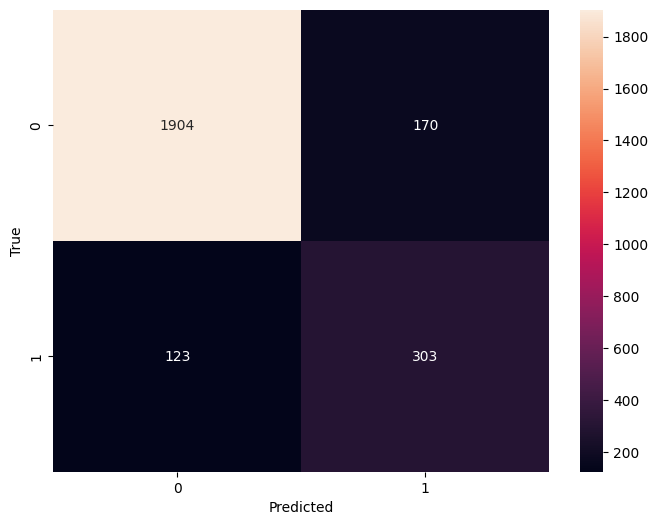

In [5]:
from keras import layers
from keras import regularizers
from keras.layers import MultiHeadAttention, Input, Reshape

input_layer = Input(shape=(len(features_i),))

# Reshape input to include a singleton dimension for timestep
reshaped_input = Reshape((1, len(features_i)))(input_layer)

# Multi-head Attention layer
multi_head_attention = MultiHeadAttention(num_heads=4, key_dim=2)(reshaped_input, reshaped_input)

# Flatten the multi-head attention output to merge the timestep dimension
flattened_attention = layers.Flatten()(multi_head_attention)
#dropout_0 = layers.Dropout(0)(flattened_attention)

# Hidden layers
hidden_layer_1 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(flattened_attention)
dropout_1 = layers.Dropout(0.2)(hidden_layer_1)
hidden_layer_2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_1)
dropout_2 = layers.Dropout(0.2)(hidden_layer_2)
hidden_layer_3 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_2)
dropout_3 = layers.Dropout(0.2)(hidden_layer_3)
hidden_layer_4 = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_3)

# Output layer
output_layer = layers.Dense(1, activation='sigmoid')(hidden_layer_4)

# Define the model
ff_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model for classification
ff_model.compile(optimizer='adam',
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

history = ff_model.fit(training_data_classes, epochs=60, validation_data=(X_val_noisy, y_val_label), verbose=2)

y_pred = ff_model.predict(X_test)

y_pred_label = (y_pred > 0.5 ).astype(int) 
cm = confusion_matrix(y_test_label, y_pred_label)

from sklearn.metrics import classification_report

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print(classification_report(y_test_label, y_pred_label))

plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


QRNN (not working)

In [ ]:
import keras
import quantnn as q

quantiles=[0.1, 0.5, 0.9]
layers = 4
neurons = 128
activation = "relu"
model = (layers, neurons, activation)
qrnn = q.QRNN(quantiles, n_inputs=1, model=model)
training_data = (X_train, y_train)
# Model setup
model = qrnn(quantiles=[0.1, 0.5, 0.9], n_inputs=len(features_i))  # Estimate 10th, 50th, 90th percentiles
results = qrnn.train(training_data=training_data, n_epochs=15)

# Model fitting
model.train(X_train, y_train, epochs=100)

# Predictions
predictions = model.predict(X_test) 
print(predictions)

In [ ]:
from typhon.retrieval.qrnn.qrnn import QRNN

# 2. Create QRNN Model (Same as before)
model = QRNN(
    quantiles=[0.1, 0.5, 0.9],  
    input_dimensions=X_train.shape[1],
    model=(3, 128, 'relu'),
    initial_learning_rate = 0.01
)

training_data = (X_train, y_train)
validation_data = (X_val, y_val)

# 3. Train the Model (Updated)
model.train(training_data, validation_data, batch_size=32) 